## Import required libraries
Modified: consolidated all imports at the beginning for better code organization

In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import math
import networkx
import networkx.algorithms
import sklearn.cluster
import sklearn.preprocessing

## Load and process company directorships data
Modified - issue: data preprocessing validation

Added validation checks for data completeness and quality after loading

In [4]:
#load the main dataset about director-company relationships
df = pandas.read_csv('company_directorships.csv')

#convert software background 't'/'f' to bool True/False
df.software_background = df.software_background.map(lambda x: x == 't')

#validate data completeness after loading
print(f"Loaded {len(df)} directorship records")
print(f"Unique directors: {df['director_name'].nunique()}")
print(f"Unique companies: {df['company_name'].nunique()}")

missing_data = df.isnull().sum()
if missing_data.any():
    print("Warning: Missing data detected:")
    print(missing_data[missing_data > 0])

#display sample to verify data loading
df.sample(5)

Loaded 13347 directorship records
Unique directors: 11827
Unique companies: 659


,company_name,cikcode,director_name,software_background,start_date,end_date
7248,"KINGSTONE COMPANIES, INC.",33992,CARLA A. D'ANDRE,False,2017-06-29,2018-06-21
580,"AMERICAN INTERNATIONAL GROUP, INC.",5272,"JAMES COLE, JR.",False,2025-04-02,2025-04-02
9533,PEPSICO INC,77476,SUSAN M. DIAMOND,False,2025-03-28,2025-03-28
11141,S&T BANCORP INC,719220,PETER G. GURT,False,2025-03-31,2025-03-31
12250,UNION BANKSHARES INC,706863,"FRANKLIN G. HOVEY, II",False,2001-04-12,2010-04-14


##  Load and process director demographic
Modified - issue: undocumented data transformation, data preprocessing validation

Added documentation for log compensation transformation and aggregation logic

Added validation checks for compensation data quality and aggregation results

In [7]:
#load the director compensation and demographic data
compensation_and_demographics_raw = pandas.read_csv('director-details.csv')

#standardize the names to uppercase for consistent merging later
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()

def most_common(series):
    """Return the most frequent value in a series (mode)"""
    mode_values = series.mode()
    if len(mode_values) > 0:
        return mode_values[0]
    return None

#aggregate director data, one row per director with combined info across all roles
compensation_and_demographics = pandas.DataFrame({
    'age': compensation_and_demographics_raw.groupby('NAME').age.max(), #take highest age if multiple entries
    'compensation': compensation_and_demographics_raw.groupby('NAME').compensation.sum(), #total compensation across roles
    'gender': compensation_and_demographics_raw.groupby('NAME').gender.agg(most_common) #most common gender listed
})

#validate compensation data after processing
print(f"Processed {len(compensation_and_demographics)} unique directors")
print(f"Zero compensation entries: {(compensation_and_demographics.compensation == 0).sum()}")
print(f"Missing age data: {compensation_and_demographics.age.isnull().sum()}")

#log transform compensation to handle extreme outliers and skewed distribution
#add 1 to handle zero compensation values (log(0) is undefined)
compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)
compensation_and_demographics

Processed 5421 unique directors
Zero compensation entries: 662
Missing age data: 0


,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
...,...,...,...,...
ZACKARY IRANI,58,360103,male,5.556428
ZAHID AFZAL,62,0,male,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5.278664


In [9]:
#check gender distribution in the director population
compensation_and_demographics.gender.value_counts(dropna=False)

gender
male       3850
female     1550
None         19
unknown       2
Name: count, dtype: int64

In [11]:
#count how many different companies each director serves on
directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()
directorship_counts

director_name
A CHARLENE SULLIVAN, PH.D.     1
MICHAEL L. KUTA                1
MICHAEL L. LARUSSO             1
MICHAEL L. MILLER              1
MICHAEL L. OWENS               1
                              ..
MARTIN L. FLANAGAN            13
ANN BARNETT STERN             13
TERESA M. RESSEL              13
BRUCE L. CROCKETT             13
ALBERT R. DOWDEN              14
Name: company_name, Length: 11827, dtype: int64

<Axes: xlabel='company_name'>

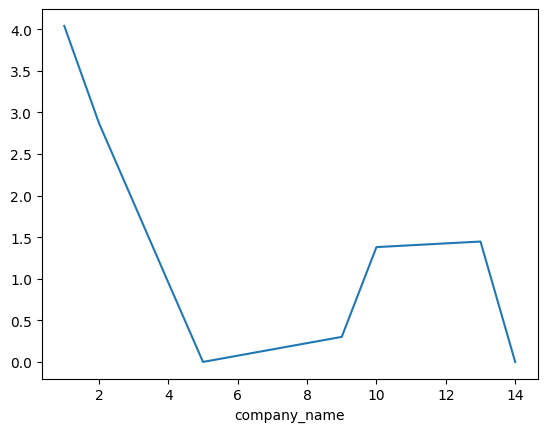

In [6]:
#plot the distribution of directorship counts
directorship_counts.value_counts().sort_index().map(math.log10).plot()

In [7]:
#create an empty graph to represent director-company relationships
#this will be a bipartite graphs, directors are connected to companies they serve
graph = networkx.Graph()

## Build the network graph

In [8]:
#build network of directors and companies
people = [] 
companies = [] 

#add edge between company and director (creates a bipartite network)
for company_name, director_name in zip(df.company_name, df.director_name):
    graph.add_edge(company_name, director_name) 
    people.append(director_name)
    companies.append(company_name)

## Extract main network component
Modified: wrong component selection

Fixed bug where [0] assumed largest component, now it explicitly finds largest by size

In [9]:
#find the largest connected component for analysis
components = list(networkx.connected_components(graph))
largest_component = max(components, key=len)
biggest_connected_graph = graph.subgraph(largest_component)
print(f"Using largest component with {len(largest_component)} nodes out of {graph.number_of_nodes()} total")

Using largest component with 8204 nodes out of 12486 total


## Calculate centrality measures
Modified: inefficient lookup

Converted people list to set for O(1) lookup instead of O(n) per node

Modified - task 1: added betweenness centrality

In [10]:
%time
centrality = pandas.DataFrame({
    'eigen': pandas.Series(networkx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pandas.Series(networkx.algorithms.degree_centrality(biggest_connected_graph)),
    'betweenness': pandas.Series(networkx.betweenness_centrality(biggest_connected_graph, k=100)),
})

#convert to set for efficient lookup
people_set = set(people)
centrality['is_person'] = centrality.index.map(lambda x: x in people_set)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


## Merge centrality data with demographics

In [24]:
people_df = centrality[centrality.is_person].merge(compensation_and_demographics, left_index=True, right_index=True)

print(f"Merged {len(people_df)} directors")

Merged 3742 directors


## Analyze most influential directors

In [12]:
#modified for task 1 - sort by eigenvector centrality to see most influential directors
print("Top directors by eigenvector centrality (most elite connections):")
print(people_df.sort_values('eigen', ascending=False)[['eigen', 'degree', 'betweenness', 'age', 'compensation']].head(10))
print("\nTop directors by betweenness centrality (best bridge/broker positions):")
print(people_df.sort_values('betweenness', ascending=False)[['eigen', 'degree', 'betweenness', 'age', 'compensation']].head(10))

Top directors by eigenvector centrality (most elite connections):
                           eigen    degree  betweenness  age  compensation
ELIZABETH KRENTZMAN     0.102439  0.001585          0.0   65       3408245
CAROL DECKBAR           0.102439  0.001585          0.0   62         43263
ELI JONES               0.102439  0.001585          0.0   63       3063255
DOUGLAS SHARP           0.102439  0.001585          0.0   50             0
JAMES "JIM" LIDDY       0.102439  0.001585          0.0   65         27531
JOEL W. MOTLEY          0.102439  0.001585          0.0   72       3118870
ROBERT C. TROCCOLI      0.102439  0.001585          0.0   75       3225755
PREMA MATHAI-DAVIS      0.102439  0.001585          0.0   74       3208265
ANTHONY J. LACAVA, JR.  0.102439  0.001585          0.0   68       3461400
BETH ANN BROWN          0.102439  0.001585          0.0   56       6363810

Top directors by betweenness centrality (best bridge/broker positions):
                                eige

## Investigate specific director

In [13]:
#look up a specific director's board positions to help validate network analysis results
df[df.director_name == 'ELIZABETH KRENTZMAN']

,company_name,cikcode,director_name,software_background,start_date,end_date
6297,Invesco Advantage Municipal Income Trust II,908993,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6352,Invesco Bond Fund,5094,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6407,Invesco California Value Municipal Income Trust,895531,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6462,Invesco High Income Trust II,846671,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6512,Invesco Municipal Income Opportunities Trust,835333,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6546,Invesco Municipal Opportunity Trust,884152,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6601,Invesco Municipal Trust,877463,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6656,Invesco Pennsylvania Value Municipal Income Trust,895528,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6706,Invesco Quality Municipal Income Trust,885125,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6740,Invesco Senior Income Trust,1059386,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02


## Prepare data for clustering

In [14]:
#use RobustScaler to handle outliers in compensation and centrality measures
robust_scaler = sklearn.preprocessing.RobustScaler()

#scale features to ensure all variables contribute equally to clustering
#combine demographic info (age, compensation) with network position (centralities)
age_and_demographics_scaled = robust_scaler.fit_transform(people_df[['age', 'log_compensation', 'degree', 'eigen', 'betweenness']])

## Perform clustering analysis

In [15]:
#use DBscan clustering to identify groups of similar directors
dbscan = sklearn.cluster.DBSCAN(eps=0.4)
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts() #show cluster distribution (-1 represents outliers/noise points)

cluster_id
 1    3117
 0     385
 2     109
-1      72
 3      24
 4      19
 7       8
 6       5
 5       3
Name: count, dtype: int64

## Visualize clustering results

<Axes: xlabel='age', ylabel='log_compensation'>

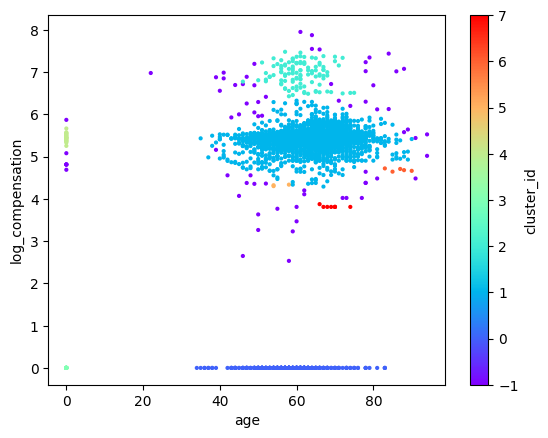

In [16]:
#create scatter plot showing director clusters by age vs compensation
people_df.plot.scatter(x='age', y='log_compensation', c='cluster_id', cmap="rainbow", s=4)

## Examine specific director profile

In [17]:
#look up detailed profile for the director investigated earlier
#shows their cluster assignment and all calculated metrics
people_df.loc['ELIZABETH KRENTZMAN']

eigen               0.102439
degree              0.001585
betweenness              0.0
is_person               True
age                       65
compensation         3408245
gender                female
log_compensation    6.532531
cluster_id                 2
Name: ELIZABETH KRENTZMAN, dtype: object

## Task 3: explore director tenure
Analyzing director tenure (length of service) as an additional dimension for identifying influential board members

In [18]:
#calculate director tenure from start and end dates
#this provides insight into director experience and established relationships
df['start_date'] = pandas.to_datetime(df['start_date'])
df['end_date'] = pandas.to_datetime(df['end_date'])
df['tenure_days'] = (df['end_date'] - df['start_date']).dt.days
df['tenure_years'] = df['tenure_days'] / 365.25

print("Director Tenure Analysis:")
print(f"Average tenure: {df['tenure_years'].mean():.1f} years")
print(f"Median tenure: {df['tenure_years'].median():.1f} years")
print(f"Longest tenure: {df['tenure_years'].max():.1f} years")
print(f"Shortest tenure: {df['tenure_years'].min():.1f} years")

Director Tenure Analysis:
Average tenure: 4.9 years
Median tenure: 4.0 years
Longest tenure: 24.0 years
Shortest tenure: 0.0 years


<Axes: >

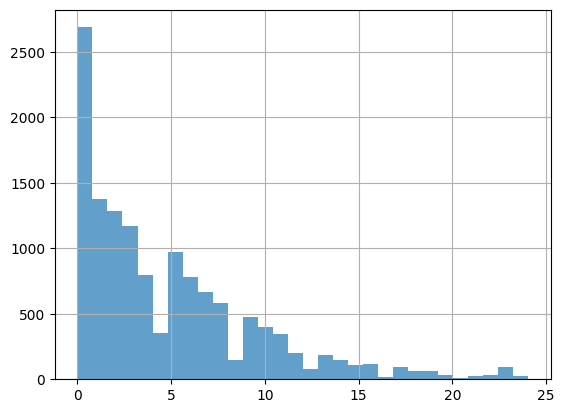

In [19]:
#visualize tenure distribution to understand director service patterns
df['tenure_years'].hist(bins=30, alpha=0.7)

In [20]:
#analyze relationship between tenure and network centrality
#longer serving directors may have more established connections for facilitating acquisitions

#merge tenure data with centrality analysis
director_tenure = df.groupby('director_name').agg({
    'tenure_years': 'mean', #average tenure across all board positions
    'company_name': 'count' #number of boards served on
}).rename(columns={'company_name': 'board_count'})

#merge with existing centrality data (convert to uppercase for matching)
director_tenure.index = director_tenure.index.str.upper()
tenure_centrality = people_df.merge(director_tenure, left_index=True, right_index=True, how='inner')

print(f"Successfully merged tenure data for {len(tenure_centrality)} directors")
print("\nSample of tenure vs centrality data:")
print(tenure_centrality[['eigen', 'betweenness', 'tenure_years', 'board_count', 'compensation']].head())

Successfully merged tenure data for 3742 directors

Sample of tenure vs centrality data:
                                  eigen  betweenness  tenure_years  \
CHRISTOPHER J. MURPHY III  2.653687e-20          0.0     16.999316   
CHRISTOPHER J. MURPHY IV   2.653687e-20          0.0     14.001369   
DANIEL B. FITZPATRICK      2.653687e-20          0.0     16.999316   
ISAAC P. TORRES            2.653687e-20          0.0      2.012320   
JOHN F. AFFLECK-GRAVES     2.653687e-20          0.0      5.002053   

                           board_count  compensation  
CHRISTOPHER J. MURPHY III            1             0  
CHRISTOPHER J. MURPHY IV             1        123120  
DANIEL B. FITZPATRICK                1        165620  
ISAAC P. TORRES                      1        166620  
JOHN F. AFFLECK-GRAVES               1        127620  


In [21]:
#identify directors with both high centrality and substantial tenure
#these represent the most valuable targets for the VC fund's acquisition strategy

#define thresholds for "high" tenure and centrality
high_tenure_threshold = tenure_centrality['tenure_years'].quantile(0.75) #top 25% by tenure
high_eigen_threshold = tenure_centrality['eigen'].quantile(0.75) #top 25% by eigenvector centrality

print(f"High tenure threshold: {high_tenure_threshold:.1f} years")
print(f"High eigenvector centrality threshold: {high_eigen_threshold:.6f}")

#find directors who are high in both tenure and centrality measures
prime_targets = tenure_centrality[
    (tenure_centrality['tenure_years'] >= high_tenure_threshold) & 
    (tenure_centrality['eigen'] >= high_eigen_threshold)
].sort_values(['eigen', 'tenure_years'], ascending=False)

print("\nPrime targets - High eigenvector centrality + High tenure:")
print(prime_targets[['eigen', 'betweenness', 'tenure_years', 'board_count', 'age', 'compensation']].head(10))

High tenure threshold: 7.6 years
High eigenvector centrality threshold: 0.000000

Prime targets - High eigenvector centrality + High tenure:
                              eigen  betweenness  tenure_years  board_count  \
PREMA MATHAI-DAVIS     1.024389e-01          0.0      8.982888           13   
ELI JONES              1.024389e-01          0.0      7.950719           13   
ROBERT C. TROCCOLI     1.024389e-01          0.0      7.950719           13   
BARRY H. GOLSEN, J.D.  3.245081e-07          0.0     13.924709            1   
LYNN F. WHITE          3.245081e-07          0.0      8.952772            1   
RICHARD W. ROEDEL      3.245081e-07          0.0      8.952772            1   
JONATHAN S. BOBB       3.245081e-07          0.0      7.953457            1   
WILLIAM C. FISHER      3.205108e-07          0.0      9.026694            1   
CHRISTOPHER J. BRAUN   3.205108e-07          0.0      8.046543            1   
DAVID W. MILES         3.205108e-07          0.0      8.046543       